# Baseline Performance Test

In [4]:
import time
import statistics

def bench(func, args, repeat=10):
    times = []
    for _ in range(repeat):
        start = time.perf_counter_ns()
        func(*args)
        times.append(time.perf_counter_ns() - start)
    return statistics.mean(times)

In [5]:
from nearorder.math.generate import base_sequence

seed = 114
seq = base_sequence(100000)
# seq

## Search Performance under In-Sequence Swaps

,disorder,inversion_count,inversion_ratio,local_inversion_ratio,max_monotonic_run,displacement_sum
0,0,0,0.000000e+00,0.000000,100000,0
1,300,300,6.000060e-08,0.002990,1974,600
2,600,596,1.192012e-07,0.005910,931,1192
3,900,896,1.792018e-07,0.008850,911,1792
4,1200,1192,2.384024e-07,0.011820,567,2384
...,...,...,...,...,...,...
195,58500,39446,7.889279e-06,0.255813,22,74924
196,58800,39686,7.937279e-06,0.255113,23,75338
197,59100,39534,7.906879e-06,0.256003,26,75164
198,59400,39654,7.930879e-06,0.256473,23,75358


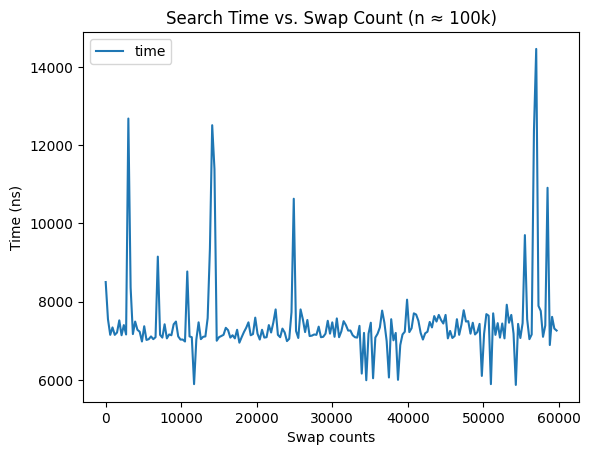

In [6]:
from nearorder.math.generate import inject_adjacent_swaps
from nearorder.math.metrics import disorder_metrics
from nearorder.bisect import binary_search

import random
import pandas as pd

num = random.randint(1, 100000)

def test_find_num(xs):
    binary_search(xs, num)

time_rows = []
disorder_rows = []

for disorder in range(0, 60000, 300):
    target = inject_adjacent_swaps(xs=seq, swaps=disorder)
    t = bench(test_find_num, args=[target])
    time_rows.append({"disorder": disorder, "time": t})
    metrics = disorder_metrics(target)
    metrics.pop('n')
    disorder_rows.append({"disorder": disorder} | metrics)

df1 = pd.DataFrame(time_rows)
ax = df1.plot(x="disorder")
ax.set_xlabel("Swap counts")
ax.set_ylabel("Time (ns)")
ax.set_title("Search Time vs. Swap Count (n ≈ 100k)")

df2 = pd.DataFrame(disorder_rows)
df2

At the 100k scale, varying the swap count between 10,000 and 60,000 results in little difference in search performance.

## Search Performance under Block-Level Disorder

,disorder,inversion_count,inversion_ratio,local_inversion_ratio,max_monotonic_run,displacement_sum
0,0,0,0.000000,0.00000,100000,0
1,50,2460000,0.000492,0.00498,749,4920000
2,100,5030000,0.001006,0.00251,1299,10060000
3,150,7890000,0.001578,0.00165,1949,15780000
4,200,10400000,0.002080,0.00123,2599,20800000
...,...,...,...,...,...,...
155,7750,360375000,0.072076,0.00004,30999,720750000
156,7800,365040000,0.073009,0.00004,31199,730080000
157,7850,369735000,0.073948,0.00004,31399,739470000
158,7900,374460000,0.074893,0.00004,31599,748920000


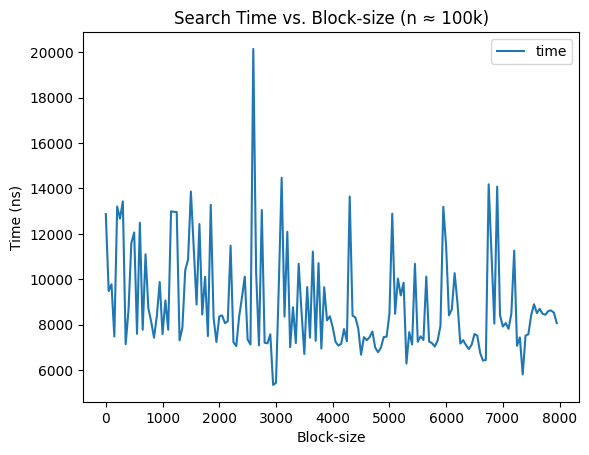

In [7]:
from nearorder.math.generate import block_shuffle

time_rows = []
disorder_rows = []

for disorder in range(0, 8000, 50):
    target = block_shuffle(seq, disorder, seed=seed)
    t = bench(test_find_num, args=[target])
    time_rows.append({"disorder": disorder, "time": t})
    metrics = disorder_metrics(target)
    metrics.pop('n')
    disorder_rows.append({"disorder": disorder} | metrics)

df1 = pd.DataFrame(time_rows)
ax = df1.plot(x="disorder")
ax.set_xlabel("Block-size")
ax.set_ylabel("Time (ns)")
ax.set_title("Search Time vs. Block-size (n ≈ 100k)")

df2 = pd.DataFrame(disorder_rows)
df2

Block size does not significantly impact search performance under typical data sizes.

## Search Performance under Periodic Local Disorder

,disorder,inversion_count,inversion_ratio,local_inversion_ratio,max_monotonic_run,displacement_sum
0,1,99999,2.000000e-05,0.00001,99999,199998
1,51,1960,3.920039e-07,0.01960,51,3920
2,101,990,1.980020e-07,0.00990,101,1980
3,151,662,1.324013e-07,0.00662,151,1324
4,201,497,9.940099e-08,0.00497,201,994
...,...,...,...,...,...,...
195,9751,10,2.000020e-09,0.00010,9751,20
196,9801,10,2.000020e-09,0.00010,9801,20
197,9851,10,2.000020e-09,0.00010,9851,20
198,9901,10,2.000020e-09,0.00010,9901,20


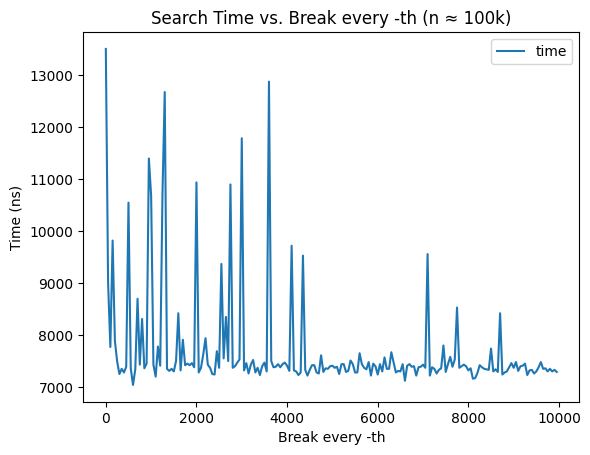

In [8]:
from nearorder.math.generate import break_runs

time_rows = []
disorder_rows = []

for disorder in range(1, 10000, 50):
    target = break_runs(seq, disorder)
    t = bench(test_find_num, args=[target])
    time_rows.append({"disorder": disorder, "time": t})
    metrics = disorder_metrics(target)
    metrics.pop('n')
    disorder_rows.append({"disorder": disorder} | metrics)

df1 = pd.DataFrame(time_rows)
ax = df1.plot(x="disorder")
ax.set_xlabel("Break every -th")
ax.set_ylabel("Time (ns)")
ax.set_title("Search Time vs. Break every -th (n ≈ 100k)")

df2 = pd.DataFrame(disorder_rows)
df2

At a data scale of approximately 100k elements, periodic local disorder within the sequence has a limited impact on average search performance.
However, when disorder breakpoints align with the search partition boundaries, additional fallback paths may be triggered, resulting in a small number of pronounced performance spikes.
This observation indicates that while the algorithm remains generally stable on near-ordered data, it exhibits structural worst-case scenarios.

## Search Performance under Periodic Shuffle

,disorder,inversion_count,inversion_ratio,local_inversion_ratio,max_monotonic_run,displacement_sum
0,0.001,3203331,0.000641,0.001000,5758,3204106
1,0.006,19739368,0.003948,0.005960,1076,19770322
2,0.011,36355942,0.007271,0.010890,621,36454364
3,0.016,54795541,0.010959,0.015860,481,55017670
4,0.021,69092198,0.013819,0.020750,418,69448838
...,...,...,...,...,...,...
195,0.976,2463336202,0.492672,0.499655,9,3261415892
196,0.981,2469774636,0.493960,0.499625,7,3276215264
197,0.986,2482586195,0.496522,0.499705,8,3296260880
198,0.991,2491150068,0.498235,0.501105,8,3309577520


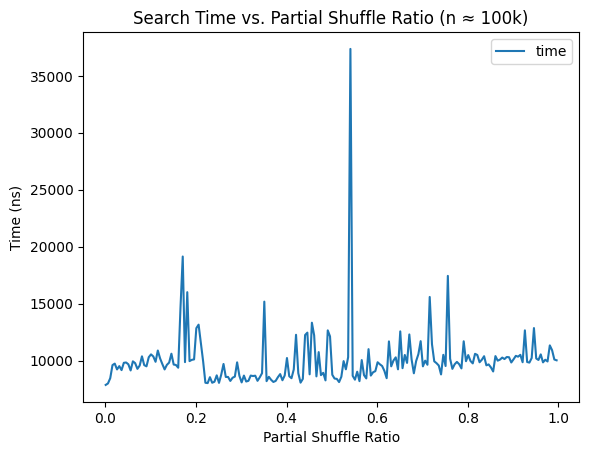

In [14]:
from nearorder.math.generate import partial_shuffle

time_rows = []
disorder_rows = []

for disorder in range(1, 1000, 5):
    disorder = disorder / 1000
    target = partial_shuffle(seq, disorder, seed=seed)
    t = bench(test_find_num, args=[target])
    time_rows.append({"disorder": disorder, "time": t})
    metrics = disorder_metrics(target)
    metrics.pop('n')
    disorder_rows.append({"disorder": disorder} | metrics)

df1 = pd.DataFrame(time_rows)
ax = df1.plot(x="disorder")
ax.set_xlabel("Partial Shuffle Ratio")
ax.set_ylabel("Time (ns)")
ax.set_title("Search Time vs. Partial Shuffle Ratio (n ≈ 100k)")

df2 = pd.DataFrame(disorder_rows)
df2

Partial random shuffling significantly increases average search time and introduces severe performance spikes, with the worst-case behavior occurring at intermediate disorder ratios where ordering assumptions are most frequently violated.